# Laboratorio 2 - Data Science

In [2]:
!pip install --upgrade pip
!pip install --upgrade numpy tensorflow
!pip install numpy==1.23.5

  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.2.0 requires numpy<2,>=1.23.2; python_version == "3.11", but you have numpy 2.1.3 which is incompatible.


  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scipy 1.16.0 requires numpy<2.6,>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.


In [3]:
import numpy as np
import tensorflow as tf

(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()
X_entreno.shape

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.23.5)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


(60000, 28, 28)

In [4]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

In [5]:
num_obs_validacion = y_prueba.shape[0]
num_obs_prueba = y_prueba.shape[0]


In [6]:
X_entreno_normalizado = X_entreno / 255
X_prueba_normalizado = X_prueba / 255

In [7]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

In [8]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

In [9]:
BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

BIG_BATCH = 10000
datos_entreno_bigbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BIG_BATCH)
datos_validacion_bigbatch = datos_validacion.batch(BIG_BATCH)
datos_prueba_bigbatch = datos_prueba.batch(BIG_BATCH)

datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BATCH_SIZE)
datos_validacion = datos_validacion.batch(BATCH_SIZE)
datos_prueba = datos_prueba.batch(BATCH_SIZE)


## Modelo

In [10]:
# Vars constantes
from matplotlib import pyplot as plt
import time
NUM_EPOCHS = 20

class RNN():
    def __init__(
            self,
            entrada,
            salida,
            capa_escondida,
        ):
        self.entrada = entrada
        self.salida = salida
        self.capa_escondida = capa_escondida
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            
            tf.keras.layers.Dense(capa_escondida, activation='relu'), # 2nda capa escondida

            tf.keras.layers.Dense(salida, activation='softmax') # capa salida
        ])
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, train_data, validation_data, num_epochs, verbose=0):
        start_time = time.time()
        self.history = self.model.fit(
            train_data,
            epochs = num_epochs, 
            validation_data = validation_data,
            verbose = verbose
        )
        end_time = time.time()
        train_loss = self.history.history['loss'][-1]
        train_acc = self.history.history['accuracy'][-1]
        val_loss = self.history.history['val_loss'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        t_time = end_time - start_time
        return (train_loss, train_acc, val_loss, val_acc, t_time)
    
    def test(self, test_data):
        loss, accuracy = self.model.evaluate(test_data)
        return (loss, accuracy)
    
    def plot_accuracy(self, title):
        plt.plot(self.history.history['accuracy'], label="Train")
        plt.plot(self.history.history['val_accuracy'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_loss(self, title):
        plt.plot(self.history.history['loss'], label="Train")
        plt.plot(self.history.history['val_loss'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

## 1. Modular Neuronas de capas internas

In [11]:
# iterar por cada una de las topologias
performance_1 = [] # almacenamiento de resultados

for inner_size in [50, 100, 200, 300, 500]:
    # Inicializar RNN
    m1 = RNN(784, 10, inner_size)
    # Compilar otpimizador
    m1.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m1.train(datos_entreno, datos_validacion, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m1.test(datos_prueba)
    performance_1.append({"Ancho": inner_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for inner size {inner_size}")
    

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 20.8516
finished for inner size 50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 18.7722
finished for inner size 100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 19.4816
finished for inner size 200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 18.7068
finished for inner size 300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 16.3083
finished for inner size 500


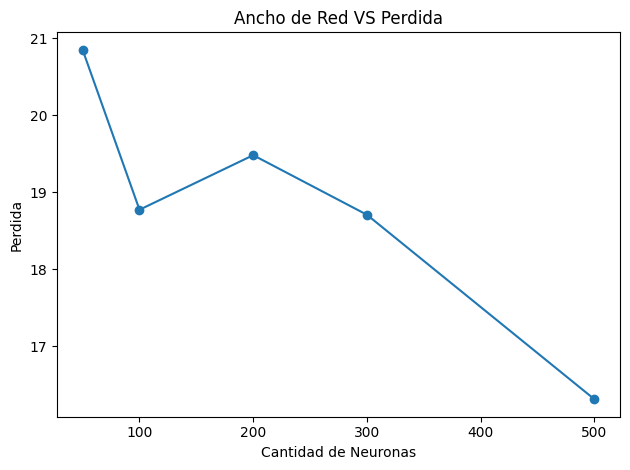

In [12]:
import pandas as pd
df1 = pd.DataFrame(performance_1)
plt.title("Ancho de Red VS Perdida")
plt.plot(df1["Ancho"], df1["t_loss"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Perdida")
plt.tight_layout()
plt.show()

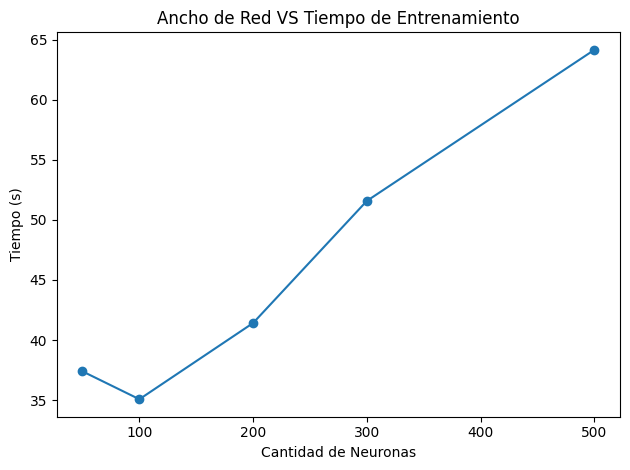

In [13]:
plt.title("Ancho de Red VS Tiempo de Entrenamiento")
plt.plot(df1["Ancho"], df1["training_time"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Tiempo (s)")
plt.tight_layout()
plt.show()

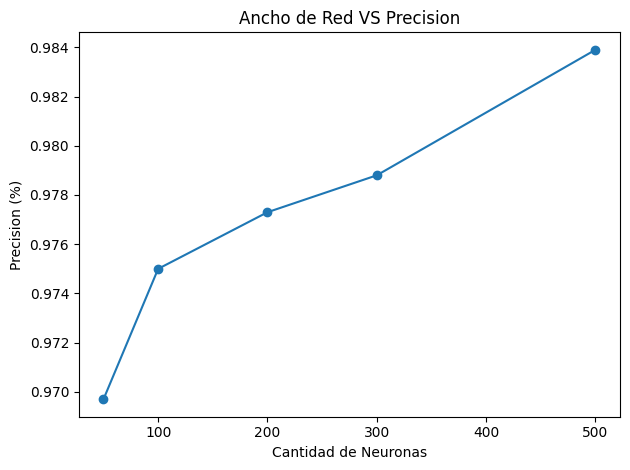

In [14]:
plt.title("Ancho de Red VS Precision")
plt.plot(df1["Ancho"], df1["t_acc"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Precision (%)")
plt.tight_layout()
plt.show()

In [15]:
df1

,Ancho,e_loss,e_acc,t_loss,t_acc,training_time
0,50,0.027090,0.99300,20.851643,0.9697,37.391201
1,100,0.008625,0.99842,18.772188,0.9750,35.071748
2,200,0.003227,0.99942,19.481609,0.9773,41.417498
3,300,0.001063,0.99980,18.706789,0.9788,51.579006
4,500,0.001828,0.99970,16.308258,0.9839,64.152178


## 2. Profundidad de Red

In [16]:
# Modelo con una capa interna
m2_one_layer = RNN(784, 10, 200)
m2_one_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_one_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelo con 2 capas internas
m2_two_layer = RNN(784, 10, 200)
m2_two_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(200, activation='relu'), # 2a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_two_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
for i, layer in enumerate(m2_one_layer.model.layers):
    weights = layer.get_weights() 
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_one_layer.model.summary()

Layer 0: flatten_6
Layer 1: dense_12
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_13
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,010 (621.13 KB)

 Trainable params: 159,010 (621.13 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
for i, layer in enumerate(m2_two_layer.model.layers):
    weights = layer.get_weights()
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_two_layer.model.summary()

Layer 0: flatten_8
Layer 1: dense_16
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_17
  Param 0 shape: (200, 200)
  Param 1 shape: (200,)
Layer 3: dense_18
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,210 (778.16 KB)

 Trainable params: 199,210 (778.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
500/500 - 3s - 6ms/step - accuracy: 0.9041 - loss: 0.3382 - val_accuracy: 0.9480 - val_loss: 0.1822
Epoch 2/20
500/500 - 2s - 4ms/step - accuracy: 0.9579 - loss: 0.1485 - val_accuracy: 0.9683 - val_loss: 0.1160
Epoch 3/20
500/500 - 2s - 4ms/step - accuracy: 0.9712 - loss: 0.1000 - val_accuracy: 0.9720 - val_loss: 0.0946
Epoch 4/20
500/500 - 2s - 4ms/step - accuracy: 0.9781 - loss: 0.0749 - val_accuracy: 0.9748 - val_loss: 0.0856
Epoch 5/20
500/500 - 2s - 4ms/step - accuracy: 0.9834 - loss: 0.0574 - val_accuracy: 0.9757 - val_loss: 0.0804
Epoch 6/20
500/500 - 2s - 4ms/step - accuracy: 0.9869 - loss: 0.0462 - val_accuracy: 0.9745 - val_loss: 0.0853
Epoch 7/20
500/500 - 2s - 4ms/step - accuracy: 0.9900 - loss: 0.0374 - val_accuracy: 0.9765 - val_loss: 0.0772
Epoch 8/20
500/500 - 2s - 4ms/step - accuracy: 0.9921 - loss: 0.0294 - val_accuracy: 0.9774 - val_loss: 0.0771
Epoch 9/20
500/500 - 2s - 4ms/step - accuracy: 0.9944 - loss: 0.0234 - val_accuracy: 0.9782 - val_loss: 0.0741
E

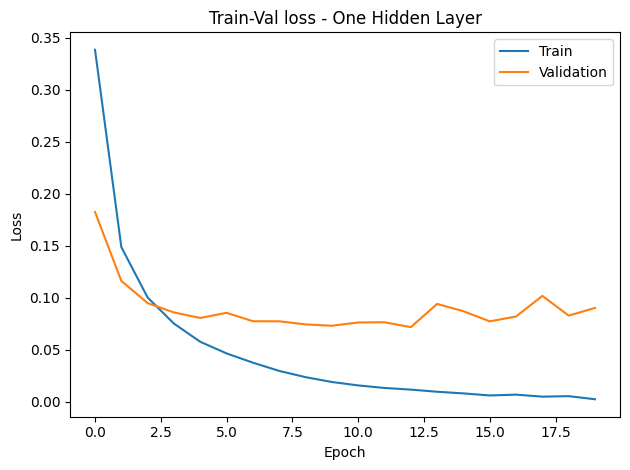

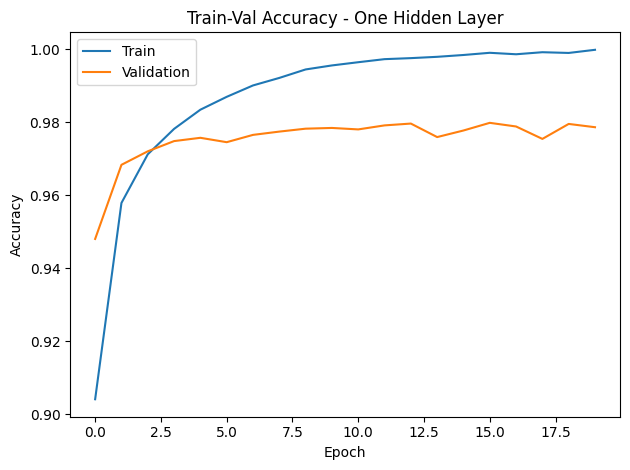

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 18.8375
Testing loss: 18.837480545043945, Testing Accuracy: 0.9783999919891357


In [19]:
# Entrenamiento 1a capa
(e_loss, e_acc, _, _, t_time) = m2_one_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m2_one_layer.plot_loss("Train-Val loss - One Hidden Layer")
m2_one_layer.plot_accuracy("Train-Val Accuracy - One Hidden Layer")
t_loss, t_acc = m2_one_layer.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 3s - 7ms/step - accuracy: 0.9165 - loss: 0.2915 - val_accuracy: 0.9594 - val_loss: 0.1348
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9655 - loss: 0.1144 - val_accuracy: 0.9695 - val_loss: 0.0992
Epoch 3/20
500/500 - 2s - 5ms/step - accuracy: 0.9773 - loss: 0.0757 - val_accuracy: 0.9732 - val_loss: 0.0901
Epoch 4/20
500/500 - 3s - 5ms/step - accuracy: 0.9835 - loss: 0.0539 - val_accuracy: 0.9746 - val_loss: 0.0889
Epoch 5/20
500/500 - 2s - 5ms/step - accuracy: 0.9865 - loss: 0.0408 - val_accuracy: 0.9785 - val_loss: 0.0759
Epoch 6/20
500/500 - 3s - 5ms/step - accuracy: 0.9909 - loss: 0.0295 - val_accuracy: 0.9777 - val_loss: 0.0870
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9916 - loss: 0.0256 - val_accuracy: 0.9786 - val_loss: 0.0850
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9946 - loss: 0.0173 - val_accuracy: 0.9766 - val_loss: 0.0886
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9949 - loss: 0.0157 - val_accuracy: 0.9776 - val_loss: 0.0853
E

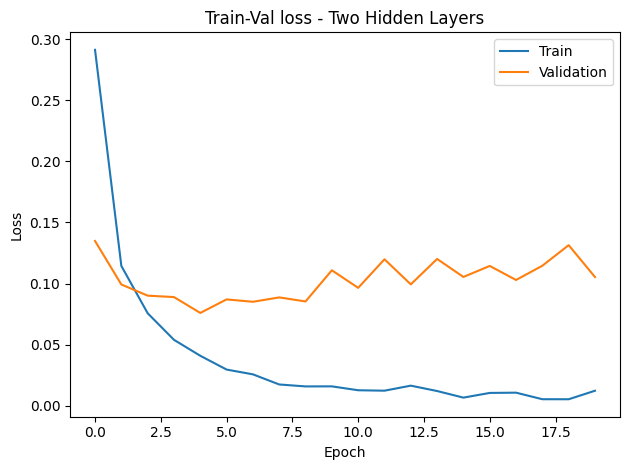

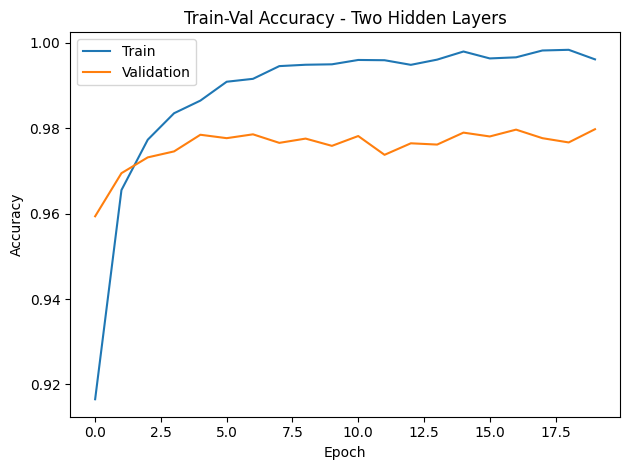

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 21.1390  
Testing loss: 21.138994216918945, Testing Accuracy: 0.9794999957084656


In [20]:
# Entrenamiento 2 capas
(e_loss, e_acc, _, _, t_time) = m2_two_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m2_two_layer.plot_loss("Train-Val loss - Two Hidden Layers")
m2_two_layer.plot_accuracy("Train-Val Accuracy - Two Hidden Layers")
t_loss, t_acc = m2_two_layer.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

## 3. Redes profunas

Epoch 1/20
500/500 - 6s - 12ms/step - accuracy: 0.9191 - loss: 0.2700 - val_accuracy: 0.9601 - val_loss: 0.1299
Epoch 2/20
500/500 - 4s - 9ms/step - accuracy: 0.9680 - loss: 0.1037 - val_accuracy: 0.9701 - val_loss: 0.0965
Epoch 3/20
500/500 - 4s - 9ms/step - accuracy: 0.9790 - loss: 0.0669 - val_accuracy: 0.9745 - val_loss: 0.0858
Epoch 4/20
500/500 - 4s - 9ms/step - accuracy: 0.9843 - loss: 0.0504 - val_accuracy: 0.9760 - val_loss: 0.0833
Epoch 5/20
500/500 - 4s - 9ms/step - accuracy: 0.9880 - loss: 0.0379 - val_accuracy: 0.9745 - val_loss: 0.0927
Epoch 6/20
500/500 - 4s - 9ms/step - accuracy: 0.9895 - loss: 0.0331 - val_accuracy: 0.9730 - val_loss: 0.0963
Epoch 7/20
500/500 - 5s - 9ms/step - accuracy: 0.9898 - loss: 0.0313 - val_accuracy: 0.9786 - val_loss: 0.0836
Epoch 8/20
500/500 - 4s - 9ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.9784 - val_loss: 0.0909
Epoch 9/20
500/500 - 4s - 9ms/step - accuracy: 0.9920 - loss: 0.0245 - val_accuracy: 0.9772 - val_loss: 0.0931


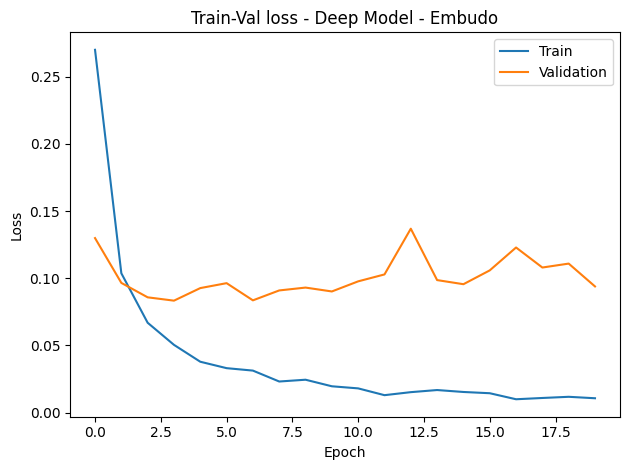

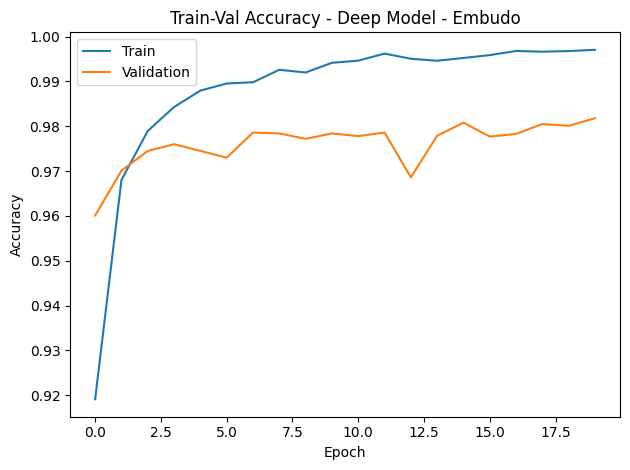

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9774 - loss: 22.3034
Testing loss: 22.303438186645508, Testing Accuracy: 0.977400004863739


In [21]:
# Init
m3_a = RNN(784, 10, 200)
m3_a.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_a.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_a.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_a.plot_loss("Train-Val loss - Deep Model - Embudo")
m3_a.plot_accuracy("Train-Val Accuracy - Deep Model - Embudo")

# Test
t_loss, t_acc = m3_a.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 6s - 11ms/step - accuracy: 0.9186 - loss: 0.2663 - val_accuracy: 0.9568 - val_loss: 0.1422
Epoch 2/20
500/500 - 4s - 8ms/step - accuracy: 0.9672 - loss: 0.1069 - val_accuracy: 0.9662 - val_loss: 0.1085
Epoch 3/20
500/500 - 4s - 8ms/step - accuracy: 0.9770 - loss: 0.0725 - val_accuracy: 0.9698 - val_loss: 0.1073
Epoch 4/20
500/500 - 4s - 8ms/step - accuracy: 0.9815 - loss: 0.0587 - val_accuracy: 0.9692 - val_loss: 0.1083
Epoch 5/20
500/500 - 4s - 8ms/step - accuracy: 0.9854 - loss: 0.0456 - val_accuracy: 0.9716 - val_loss: 0.1084
Epoch 6/20
500/500 - 4s - 8ms/step - accuracy: 0.9878 - loss: 0.0397 - val_accuracy: 0.9771 - val_loss: 0.0860
Epoch 7/20
500/500 - 4s - 8ms/step - accuracy: 0.9884 - loss: 0.0369 - val_accuracy: 0.9770 - val_loss: 0.0961
Epoch 8/20
500/500 - 4s - 8ms/step - accuracy: 0.9908 - loss: 0.0292 - val_accuracy: 0.9779 - val_loss: 0.0918
Epoch 9/20
500/500 - 4s - 8ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.9759 - val_loss: 0.1033


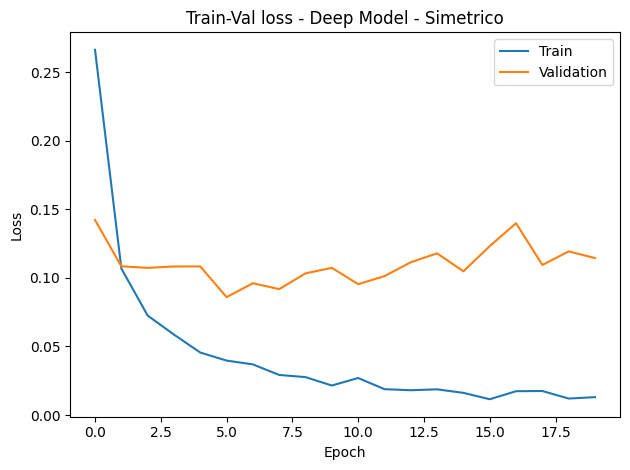

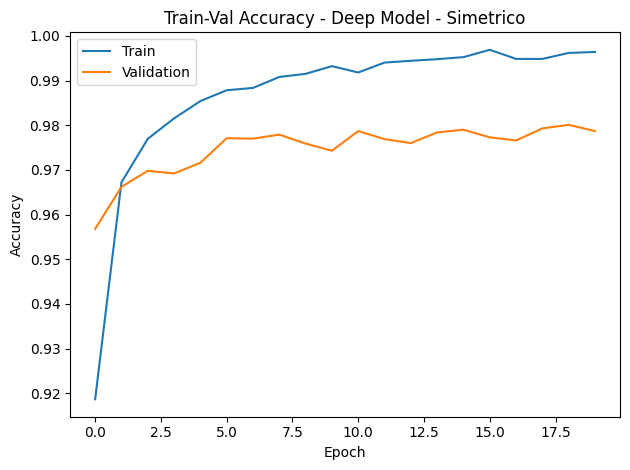

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9782 - loss: 21.8277
Testing loss: 21.827714920043945, Testing Accuracy: 0.9782000184059143


In [22]:
# Init
m3_b = RNN(784, 10, 200)
m3_b.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_b.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_b.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_b.plot_loss("Train-Val loss - Deep Model - Simetrico")
m3_b.plot_accuracy("Train-Val Accuracy - Deep Model - Simetrico")

# Test
t_loss, t_acc = m3_b.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 6s - 13ms/step - accuracy: 0.9146 - loss: 0.2808 - val_accuracy: 0.9588 - val_loss: 0.1374
Epoch 2/20
500/500 - 4s - 7ms/step - accuracy: 0.9666 - loss: 0.1098 - val_accuracy: 0.9660 - val_loss: 0.1140
Epoch 3/20
500/500 - 4s - 8ms/step - accuracy: 0.9764 - loss: 0.0774 - val_accuracy: 0.9733 - val_loss: 0.0965
Epoch 4/20
500/500 - 4s - 7ms/step - accuracy: 0.9811 - loss: 0.0570 - val_accuracy: 0.9733 - val_loss: 0.1001
Epoch 5/20
500/500 - 4s - 7ms/step - accuracy: 0.9852 - loss: 0.0469 - val_accuracy: 0.9789 - val_loss: 0.0740
Epoch 6/20
500/500 - 4s - 7ms/step - accuracy: 0.9879 - loss: 0.0393 - val_accuracy: 0.9748 - val_loss: 0.0944
Epoch 7/20
500/500 - 4s - 7ms/step - accuracy: 0.9899 - loss: 0.0321 - val_accuracy: 0.9791 - val_loss: 0.0822
Epoch 8/20
500/500 - 4s - 7ms/step - accuracy: 0.9903 - loss: 0.0320 - val_accuracy: 0.9765 - val_loss: 0.0933
Epoch 9/20
500/500 - 4s - 7ms/step - accuracy: 0.9917 - loss: 0.0269 - val_accuracy: 0.9760 - val_loss: 0.1061


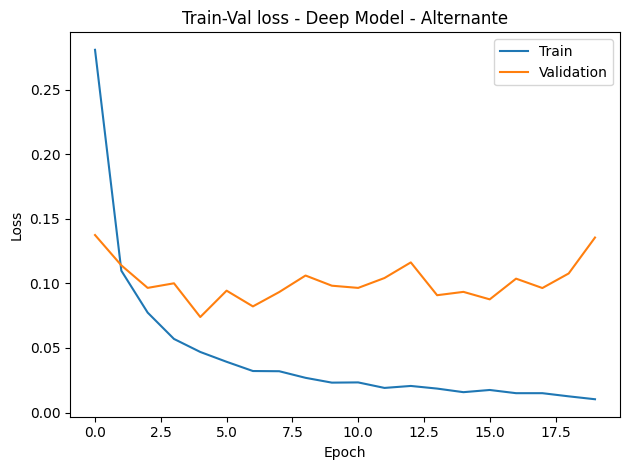

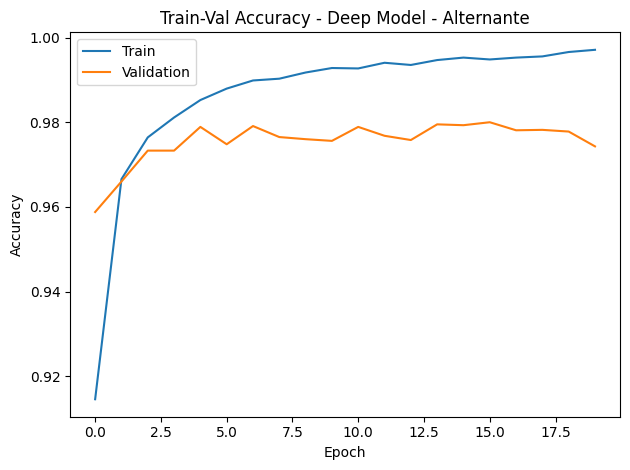

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 32.2587
Testing loss: 32.25873565673828, Testing Accuracy: 0.9692000150680542


In [23]:
# kida random
# Init
m3_c = RNN(784, 10, 200)
m3_c.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_c.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_c.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_c.plot_loss("Train-Val loss - Deep Model - Alternante")
m3_c.plot_accuracy("Train-Val Accuracy - Deep Model - Alternante")

# Test
t_loss, t_acc = m3_c.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 4. Funciones de Activacion 1

Epoch 1/20
500/500 - 6s - 11ms/step - accuracy: 0.6509 - loss: 0.9686 - val_accuracy: 0.8883 - val_loss: 0.3896
Epoch 2/20
500/500 - 4s - 8ms/step - accuracy: 0.9166 - loss: 0.2955 - val_accuracy: 0.9423 - val_loss: 0.2024
Epoch 3/20
500/500 - 4s - 8ms/step - accuracy: 0.9457 - loss: 0.1898 - val_accuracy: 0.9546 - val_loss: 0.1569
Epoch 4/20
500/500 - 4s - 8ms/step - accuracy: 0.9578 - loss: 0.1463 - val_accuracy: 0.9620 - val_loss: 0.1300
Epoch 5/20
500/500 - 4s - 8ms/step - accuracy: 0.9659 - loss: 0.1184 - val_accuracy: 0.9621 - val_loss: 0.1303
Epoch 6/20
500/500 - 4s - 8ms/step - accuracy: 0.9713 - loss: 0.0992 - val_accuracy: 0.9677 - val_loss: 0.1093
Epoch 7/20
500/500 - 4s - 8ms/step - accuracy: 0.9754 - loss: 0.0851 - val_accuracy: 0.9701 - val_loss: 0.1018
Epoch 8/20
500/500 - 4s - 8ms/step - accuracy: 0.9788 - loss: 0.0725 - val_accuracy: 0.9631 - val_loss: 0.1203
Epoch 9/20
500/500 - 4s - 8ms/step - accuracy: 0.9815 - loss: 0.0634 - val_accuracy: 0.9683 - val_loss: 0.1091


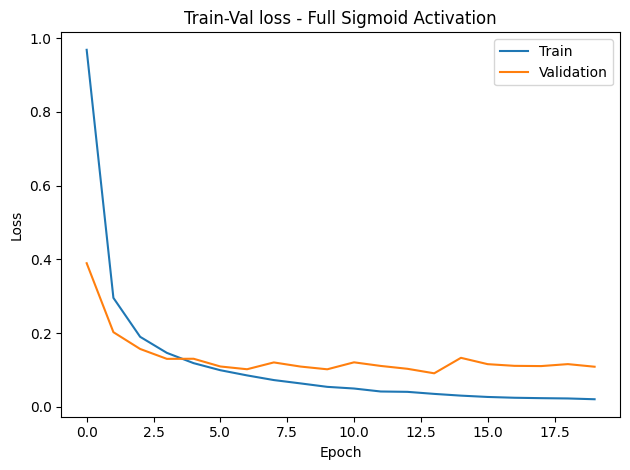

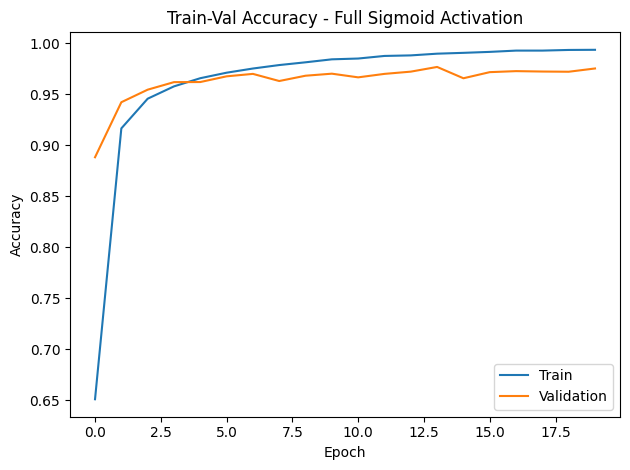

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9629 - loss: 0.1685
Testing loss: 0.16854503750801086, Testing Accuracy: 0.9628999829292297


In [24]:
# Init
m4 = RNN(784, 10, 200)
m4.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m4.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m4.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m4.plot_loss("Train-Val loss - Full Sigmoid Activation")
m4.plot_accuracy("Train-Val Accuracy - Full Sigmoid Activation")

# Test
t_loss, t_acc = m4.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 5. Funciones de Activacion 2

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.9265 - loss: 0.2485 - val_accuracy: 0.9655 - val_loss: 0.1158
Epoch 2/20
500/500 - 3s - 6ms/step - accuracy: 0.9700 - loss: 0.0962 - val_accuracy: 0.9686 - val_loss: 0.1035
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9804 - loss: 0.0610 - val_accuracy: 0.9732 - val_loss: 0.0903
Epoch 4/20
500/500 - 3s - 5ms/step - accuracy: 0.9859 - loss: 0.0436 - val_accuracy: 0.9735 - val_loss: 0.0895
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9896 - loss: 0.0311 - val_accuracy: 0.9763 - val_loss: 0.0837
Epoch 6/20
500/500 - 3s - 6ms/step - accuracy: 0.9922 - loss: 0.0230 - val_accuracy: 0.9767 - val_loss: 0.0846
Epoch 7/20
500/500 - 3s - 6ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9792 - val_loss: 0.0838
Epoch 8/20
500/500 - 3s - 6ms/step - accuracy: 0.9933 - loss: 0.0191 - val_accuracy: 0.9764 - val_loss: 0.0994
Epoch 9/20
500/500 - 3s - 6ms/step - accuracy: 0.9949 - loss: 0.0148 - val_accuracy: 0.9781 - val_loss: 0.0959
E

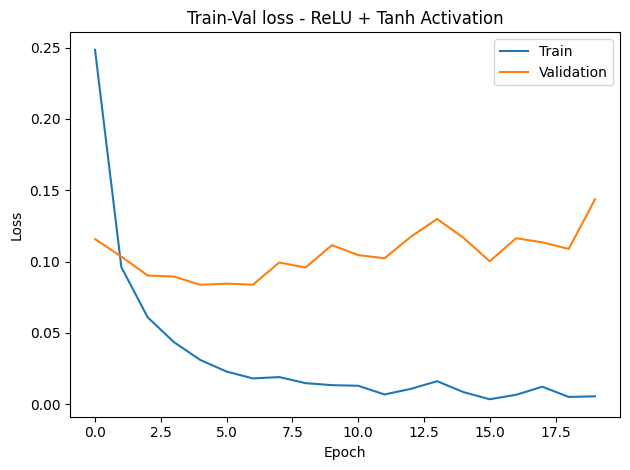

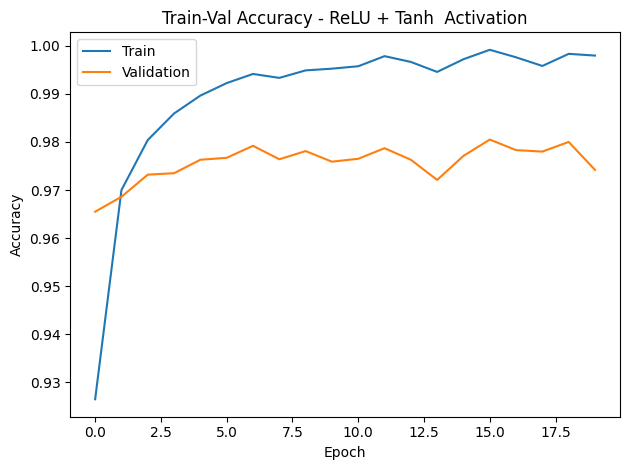

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9758 - loss: 0.1500
Testing loss: 0.15000750124454498, Testing Accuracy: 0.9757999777793884


In [25]:
# Init
m5 = RNN(784, 10, 200)
m5.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m5.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m5.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m5.plot_loss("Train-Val loss - ReLU + Tanh Activation")
m5.plot_accuracy("Train-Val Accuracy - ReLU + Tanh  Activation")

# Test
t_loss, t_acc = m5.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 6. Tamaño Batch Grande

Epoch 1/20
5/5 - 2s - 358ms/step - accuracy: 0.4794 - loss: 1.8559 - val_accuracy: 0.7946 - val_loss: 1.1851
Epoch 2/20
5/5 - 1s - 140ms/step - accuracy: 0.7933 - loss: 0.9620 - val_accuracy: 0.8566 - val_loss: 0.6186
Epoch 3/20
5/5 - 1s - 143ms/step - accuracy: 0.8491 - loss: 0.5728 - val_accuracy: 0.8832 - val_loss: 0.4200
Epoch 4/20
5/5 - 1s - 141ms/step - accuracy: 0.8769 - loss: 0.4268 - val_accuracy: 0.9004 - val_loss: 0.3420
Epoch 5/20
5/5 - 1s - 139ms/step - accuracy: 0.8935 - loss: 0.3573 - val_accuracy: 0.9135 - val_loss: 0.2984
Epoch 6/20
5/5 - 1s - 143ms/step - accuracy: 0.9060 - loss: 0.3141 - val_accuracy: 0.9214 - val_loss: 0.2699
Epoch 7/20
5/5 - 1s - 138ms/step - accuracy: 0.9157 - loss: 0.2834 - val_accuracy: 0.9279 - val_loss: 0.2492
Epoch 8/20
5/5 - 1s - 140ms/step - accuracy: 0.9224 - loss: 0.2605 - val_accuracy: 0.9327 - val_loss: 0.2330
Epoch 9/20
5/5 - 1s - 139ms/step - accuracy: 0.9289 - loss: 0.2421 - val_accuracy: 0.9356 - val_loss: 0.2205
Epoch 10/20
5/5 - 1

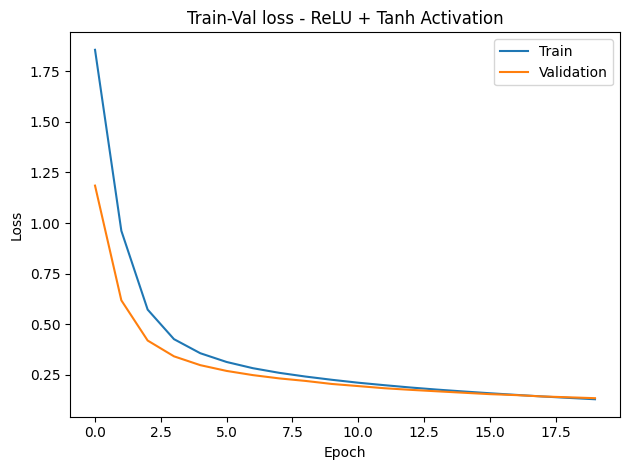

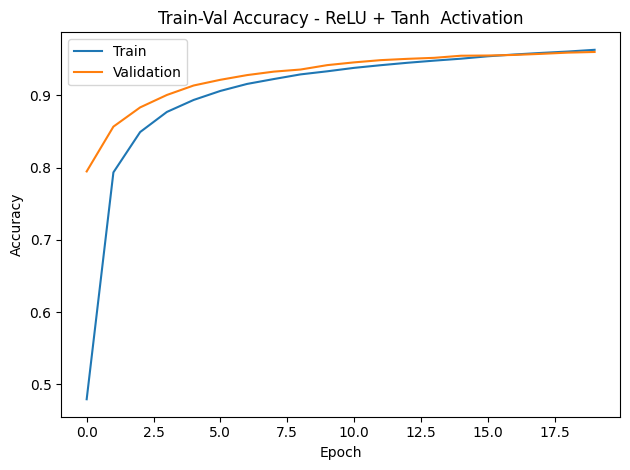

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9569 - loss: 0.1584
Testing loss: 0.15835849940776825, Testing Accuracy: 0.9569000005722046


In [26]:
# Init
m6 = RNN(784, 10, 200)
m6.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m6.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m6.train(datos_entreno_bigbatch, datos_validacion_bigbatch, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m6.plot_loss("Train-Val loss - ReLU + Tanh Activation")
m6.plot_accuracy("Train-Val Accuracy - ReLU + Tanh  Activation")

# Test
t_loss, t_acc = m6.test(datos_prueba_bigbatch)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")